In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py, time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import scipy

import sys
sys.path.append('../../..')
import mutagenesisfunctions as mf
import bpdev as bd
import helper
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency

import contacts

from Bio import AlignIO
import time as time
import pandas as pd
np.random.seed(42)

In [12]:
#import the performances file
perffile = 'test_metrics.csv'
perf = pd.read_csv(perffile)
perf.head()

,Date,Model Architecture,Hidden Layer Size,Family,NumTrained,Loss,Accuracy,AUC-roc,AUC-pr,Somcalctime
0,2019-02-03,mlp,512,RF00002,4000,0.007517,0.999000,0.999988,0.999988,1305.617981
1,2019-02-03,mlp,512,RF00002,2000,0.009160,0.996000,1.000000,1.000000,656.068606
2,2019-02-03,mlp,512,RF00002,1000,0.002223,1.000000,1.000000,1.000000,327.704883
3,2019-02-03,mlp,512,RF00002,500,0.058226,0.991935,0.999480,0.999480,164.543710
4,2019-02-03,mlp,512,RF00002,250,0.156247,0.951613,0.990635,0.991826,82.330009


In [13]:
#impport info file
#Remember these are all the families that are greater than 5000 sequences deep
info = pd.read_csv('marks_ts_info.csv', index_col=0)
info = info.set_index('RFAM_ID')
inforel = info[info.index != 'RF01960']
inforel

,Length,M,M_eff
RFAM_ID,,,
RF00002,155,375612,1197.3
RF00005,73,298470,3533.2
RF00010,359,6397,1215.1
RF00017,300,22685,4358.5
RF00023,366,5983,1558.9
RF00059,105,11197,2249.5
RF00169,99,5622,637.2
RF00174,188,9056,3190.6
RF00504,91,6875,895.1


In [14]:
def quant_contacts(fam, numhidden, numtrain, comp='cWW_int', min_dist=5.0):
# using the threshold of L/2
    ######### EXTRACT DATA ###########

    #extract SoM results after an APC correction
    arrayspath = 'Arrays/mlp_%s_%s_ts%s.npy'%(numhidden,fam,numtrain)
    hol_mut2 = np.load(arrayspath)
    seqlen,_, dims,_ = hol_mut2.shape
    C = bd.get_wc(arrayspath, seqlen, dims, bpugSQ=0, denoise='APC')

    #Load in the EC annotation
    ECannotfile = '../marks/%s/%s.EC.interaction.txt'%(fam,fam) 
    EC_df = pd.read_csv(ECannotfile, delimiter='\s+')

    ######### QUALITATIVE CONTACTS ###########
    #All cWW annotated interactions
    cWW_int = EC_df[EC_df['interactions'] == 'cWW']
    #All PDB contacts < 8 angstroms
    close_cont = EC_df[EC_df['minimum_atom_distance'] <= min_dist] 

    ######### QUANTITATIVE GRAPHS ###########

    #Get the real positive and negative pdb contacts
    def groundtruth(comp=comp):

        if comp == 'atom_dist':
            real_pos = np.zeros((seqlen,seqlen))
            for ii in range(len(close_cont)):
                real_pos[close_cont.iloc[ii, 1], close_cont.iloc[ii, 2]] = 1.
            real_neg = np.ones((seqlen,seqlen))
            for ii in range(len(close_cont)):
                real_neg[close_cont.iloc[ii, 1], close_cont.iloc[ii, 2]] = 0.
                
        if comp == 'cWW_int':
            real_pos = np.zeros((seqlen,seqlen))
            for ii in range(len(cWW_int)):
                real_pos[cWW_int.iloc[ii, 1], cWW_int.iloc[ii, 2]] = 1.
            real_neg = np.ones((seqlen,seqlen))
            for ii in range(len(cWW_int)):
                real_neg[cWW_int.iloc[ii, 1], cWW_int.iloc[ii, 2]] = 0.
        return (real_pos, real_neg)

    def sumstats_mi(thresh):
        #Get the top thresh Gtest scores
        g_pos = bd.plot_wcrank(gtest, seqlen, thresh*2)
        g_pos[np.tril_indices(seqlen)] = 0.
        #Get the bottom thresh SoM scores
        g_neg = (~g_pos.astype('bool'))*1 #incantation converts binary to boolean, flips them then back to binary

        TP = np.sum(real_pos*g_pos)
        FP = np.sum(real_neg*g_pos)
        TN = np.sum(real_neg*g_neg)
        FN = np.sum(real_pos*g_neg)

        PPV = TP/(TP+FP)
        FDR = FP/(TP+FP)
        TPR = TP/(TP+FN)

        return (PPV, FDR, TPR, TP, FP, TN, FN)
    
    def sumstats(thresh):
        #Get the top thresh SoM scores
        som_pos = bd.plot_wcrank(C, seqlen, thresh*2)
        som_pos[np.tril_indices(seqlen)] = 0.
        #Get the bottom thresh SoM scores
        som_neg = (~som_pos.astype('bool'))*1 #incantation converts binary to boolean, flips them then back to binary

        TP = np.sum(real_pos*som_pos)
        FP = np.sum(real_neg*som_pos)
        TN = np.sum(real_neg*som_neg)
        FN = np.sum(real_pos*som_neg)

        PPV = TP/(TP+FP)
        FDR = FP/(TP+FP)
        TPR = TP/(TP+FN)

        return (PPV, FDR, TPR, TP, FP, TN, FN)

    def sumstats_EC(thresh):
        #Top thresh EC scores
        n_EC_P = len(EC_df.iloc[:thresh, :])
        EC_pos = np.zeros((seqlen,seqlen))
        for ii in range(n_EC_P):
            EC_pos[EC_df.iloc[ii, 1], EC_df.iloc[ii, 2]] = 1.
        EC_neg = np.ones((seqlen,seqlen))
        for ii in range(n_EC_P):
            EC_neg[EC_df.iloc[ii, 1], EC_df.iloc[ii, 2]] = 0.

        TP = np.sum(real_pos*EC_pos)
        FP = np.sum(real_neg*EC_pos)
        TN = np.sum(real_neg*EC_neg)
        FN = np.sum(real_pos*EC_neg)

        PPV = TP/(TP+FP)
        FDR = FP/(TP+FP)
        TPR = TP/(TP+FN)

        return (PPV, FDR, TPR, TP, FP, TN, FN)
    
    real_pos, real_neg = groundtruth(comp=comp)
    #ecst = sumstats_EC(tr)
    somst = sumstats(seqlen//2)
    #gst = sumstats_mi(tr)
    
    return (somst[0], somst[2])



families: ['RF00002',
 'RF00005',
 'RF00010',
 'RF00017',
 'RF00023',
 'RF00059',
 'RF00169',
 'RF00174',
 'RF00504',
 'RF01960']
 
 For this data there will be two values (PPV, TPR) per numhidden, family and trainsize. 
 I think I should just make the data as tidy from the beginning to reduce my headache. 
 Keys will be -> Family, Length, M, M_eff, ts, numhidden, PPV, TPR

In [15]:
#we use the families that are from the ts_info file
families = list(inforel.index)
trainsizes = list(set(perf['NumTrained']))

numhidden_list = [512]

total_exp = len(families)*len(trainsizes)*len(numhidden_list)

#initialize the empty dataframe to be filled in
keys = ['Family', 'Length', 'M', 'M_eff', 'Numtrain', 'numhidden', 'PPV', 'TPR', 'Accuracy', 'AUC-roc']
statsdf = pd.DataFrame(index=np.arange(total_exp), columns=keys)



In [16]:
#start for loop
k = 0
for fam in families:
    for ts in trainsizes:
        for numhidden in numhidden_list:
            s = quant_contacts(fam, numhidden, ts, comp='cWW_int', min_dist=5.0)
            perfidx = (perf['Hidden Layer Size']==numhidden) & (perf['Family']==fam) & (perf['NumTrained']==int(ts))
            statsdf.iloc[k, :] = [fam, info.loc[fam, 'Length'],info.loc[fam, 'M'],info.loc[fam, 'M_eff'],
                                 ts, numhidden, s[0], s[1], perf['Accuracy'].loc[perfidx].iloc[0], perf['AUC-roc'].loc[perfidx].iloc[0]]
            if k%10 == 0:
                print (k)
            k += 1

0
10
20
30
40
50
60
70
80


In [17]:
statsdf = statsdf.apply(pd.to_numeric, errors='ignore')

In [18]:
#save the stats
statsfile = 'marks_ts_stats.csv'
statsdf.to_csv(statsfile)

In [39]:
statsfile = 'marks_ts_stats.csv'
statsdf = pd.read_csv(statsfile)

In [43]:
maxtprs = statsdf[statsdf['Numtrain'] == 4000][['Family', 'TPR']].set_index('Family')

for ii in statsdf.index:
    if maxtprs.loc[statsdf.loc[ii, 'Family'], 'TPR'] == 0:
        statsdf.loc[ii, 'TPR_norm'] = 0
    else:
        statsdf.loc[ii, 'TPR_norm'] = statsdf.loc[ii, 'TPR']/maxtprs.loc[statsdf.loc[ii, 'Family'], 'TPR']

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


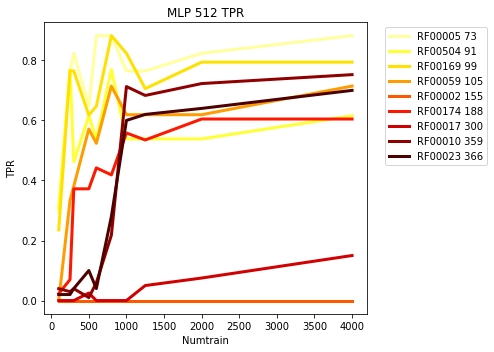

In [46]:
fig = plt.figure(figsize=(7,5))
ax2 = fig.add_subplot(1,1,1)
lw = 3.0
cmp = 'hot_r'
hrder = list(inforel.sort_values('Length').index)
leg_labels = ['%s %s'%(f,inforel['Length'].loc[f]) for f in hrder]

ax2 = sb.lineplot(data=statsdf, x='Numtrain', y='TPR', hue='Family', linewidth=lw, palette=cmp, hue_order=hrder)
ax2.set_title('MLP 512 TPR')
ax2.get_legend().remove()
plt.legend(labels = leg_labels, bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

/Users/steffanpaul/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


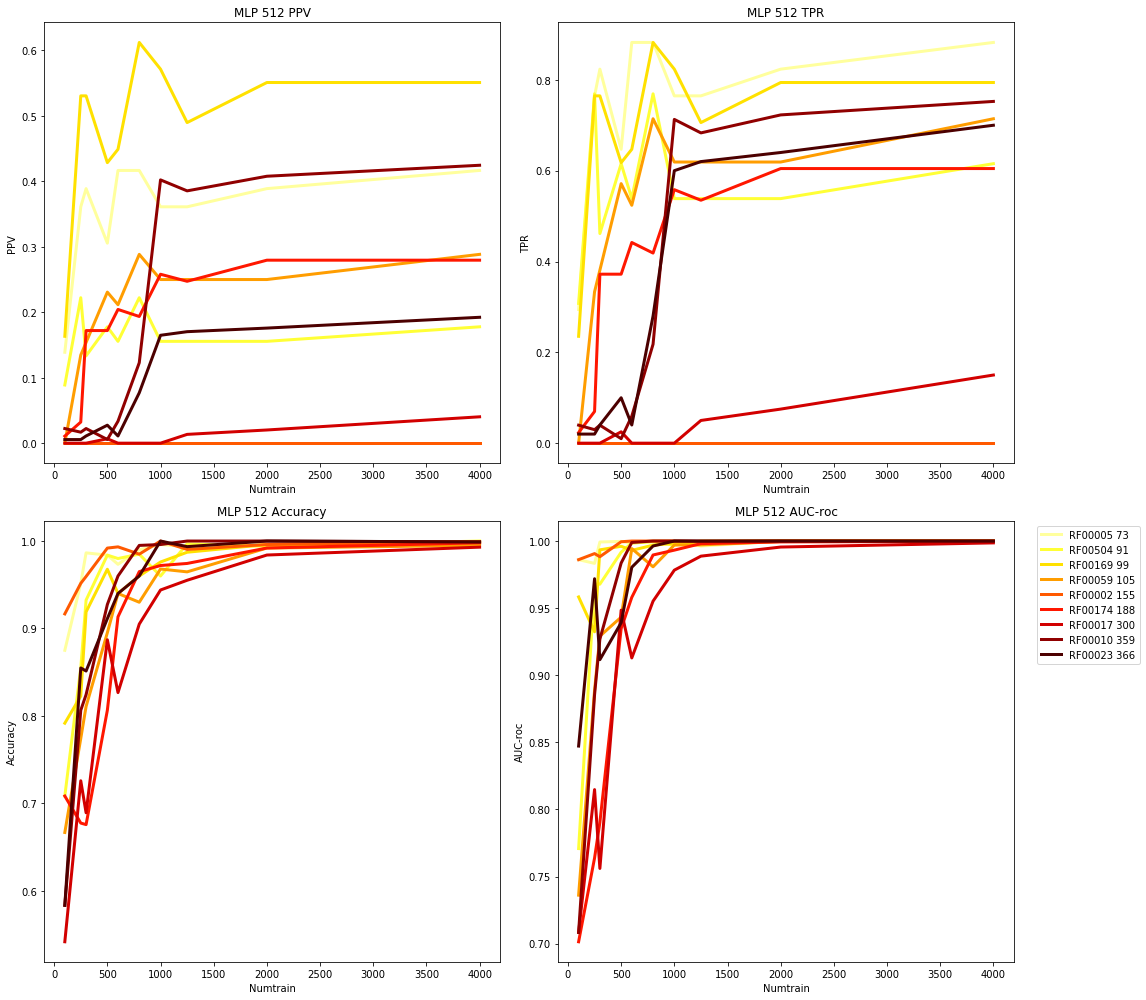

In [29]:
#visualize
#statsdf = statsdf[statsdf['Numtrain'] <= 2000]
fig = plt.figure(figsize=(16,14))

lw = 3.0
cmp = 'hot_r'
hrder = list(inforel.sort_values('Length').index)
leg_labels = ['%s %s'%(f,inforel['Length'].loc[f]) for f in hrder]

ax1 = fig.add_subplot(2,2,1)
ax1 = sb.lineplot(data=statsdf, x='Numtrain', y='PPV', hue='Family', linewidth=lw, palette=cmp, hue_order=hrder)
ax1.set_title('MLP 512 PPV')
ax1.get_legend().remove()

ax2 = fig.add_subplot(2,2,2)
ax2 = sb.lineplot(data=statsdf, x='Numtrain', y='TPR', hue='Family', linewidth=lw, palette=cmp, hue_order=hrder)
ax2.set_title('MLP 512 TPR')
ax2.get_legend().remove()

ax3 = fig.add_subplot(2,2,3)
ax3 = sb.lineplot(data=statsdf, x='Numtrain', y='Accuracy', hue='Family', linewidth=lw, palette=cmp, hue_order=hrder)
ax3.set_title('MLP 512 Accuracy')
ax3.get_legend().remove()

ax4 = fig.add_subplot(2,2,4)
ax4 = sb.lineplot(data=statsdf, x='Numtrain', y='AUC-roc', hue='Family', linewidth=lw, palette=cmp, hue_order=hrder)
ax4.set_title('MLP 512 AUC-roc')
ax4.get_legend().remove()

plt.legend(labels = leg_labels, bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

The fact that there is a spike at 100 for so many families is weird because especially looking at their WC plots we see that the plots are actually noisier than the higher trainsize exps.